# Exercise 1

## Imports

In [1]:
from io import SEEK_CUR
import os.path as path
import pandas as pd
import gzip

## Prepare the data

In [2]:
high_energy_dataset = 'ca-HepPh.txt.gz'
facebook_dataset = 'facebook_combined.txt.gz'
pathways_dataset = 'PP-Pathways_ppi.csv.gz'
data_folder = 'data'

In [3]:
def load_dataset(dataset: str, data_folder: str = data_folder) -> pd.DataFrame:
    pt = path.join(data_folder, dataset)
    
    if dataset == 'ca-HepPh.txt.gz':
        with gzip.open(pt, 'rb') as f:
            c = f.read(1)
            while c == b'#':
                f.readline()
                c = f.read(1)
            f.seek(-1, SEEK_CUR)
            return pd.read_csv(f, sep='\t', header=None)
        
    elif dataset == 'facebook_combined.txt.gz':
        return pd.read_csv(pt, sep=' ', header=None)

    return pd.read_csv(pt, header=None)

In [19]:
dataset = load_dataset(facebook_dataset).rename(columns={0: 'source', 1: 'target'})

## Our implementation

In [ ]:
# TODO

In [1]:
n_clusters_ideal = 8    # TODO: choose an appropriate value

## Scikit-learn Spectral Clustering

In [15]:
from sklearn.cluster import SpectralClustering

# SpectralClustering(n_clusters_ideal, eigen_solver='lobpcg').fit(dataset)

MemoryError: Unable to allocate 58.0 GiB for an array with shape (88234, 88234) and data type float64

## Spark Power Iteration Clustering

In [5]:
from pyspark.ml.clustering import PowerIterationClustering
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder \
    .appName('SpectralClustering') \
    .config('spark.master', 'local[*]') \
    .getOrCreate()

23/05/23 20:52:50 WARN Utils: Your hostname, martinho-MS-7B86 resolves to a loopback address: 127.0.1.1; using 192.168.1.67 instead (on interface enp34s0)
23/05/23 20:52:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/23 20:52:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [45]:
dataset_spark = spark.createDataFrame(dataset)

Add the weight column (all at 1s).

In [46]:
dataset_spark = dataset_spark.withColumn('weight', F.lit(1))

In [47]:
pic = PowerIterationClustering(k=2, maxIter=20, initMode="degree", srcCol='source', dstCol='target', weightCol="weight")
dataset_clustered = pic.assignClusters(dataset_spark).toPandas()

## Visualization

In [23]:
import networkx as nx

g = nx.from_pandas_edgelist(dataset.sample(1000), create_using=nx.DiGraph)

In [72]:
for node in g.nodes:
    g.nodes[node]['cluster'] = dataset_clustered[dataset_clustered['id'] == node]['cluster'].values[0]

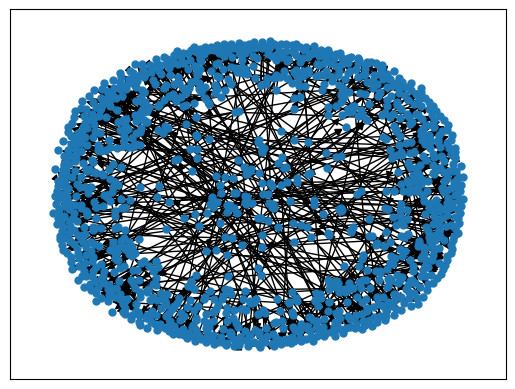

In [40]:
nx.draw_networkx(g, edgelist=[], arrows=False, node_size=25, with_labels=False)